In [ ]:
import jax
from jax import random
from jax import numpy as jnp
import json
import mediapy
import optax
import os
import pickle
from PIL import Image

import sys

sys.path.append('./')
sys.path.append('../')

from waymax import agents
from waymax import config as _config
from waymax import dynamics
from waymax import dataloader
from waymax import datatypes
from waymax import env as _env
from waymax import visualization

from flax.training.train_state import TrainState

import sys
sys.path.append('../')
sys.path.append('./')

from model.feature_extractor import FlattenXYExtractor
from model.state_preprocessing import ExtractXY
from model.rnn_policy import ActorCriticRNN, ScannedRNN

: 

In [2]:
# # Training config
# config = {
#     'anneal_lr': False,
#     'bins': 128,
#     'discrete': False,
#     'key': 42,
#     'lr': 3e-4,
#     "max_grad_norm": 0.5,
#     'max_num_obj': 8,
#     'max_num_rg_points': 20000,
#     'num_envs': 4,
#     'num_envs_eval': 1,
#     "num_epochs": 1,
#     'num_steps': 80,
#     "n_train_per_epoch": 1000,
#     'roadgraph_top_k': 100,
#     'shuffle_seed': 123,
#     'shuffle_buffer_size': 1_000,
#     'total_timesteps': 100,
#     'training_path': '/data/saruman/cleain/WOD_1_1_0/tf_example/training/training_tfexample.tfrecord@1000',
#     'validation_path': '/data/saruman/cleain/WOD_1_1_0/tf_example/validation/validation_tfexample.tfrecord@150'
#     }

load_folder = '/data/saruman/cleain/imitation_gap_womd/logs'
expe_num = '20231110_110443'

with open(os.path.join(load_folder, expe_num, 'args.json'), 'r') as file:
    config = json.load(file)

## Training Curves

In [23]:
with open(os.path.join(load_folder, expe_num, 'training_metrics_99.pkl'), 'rb') as file:
    training_dict = pickle.load(file)

In [24]:
# import jax.numpy as jnp
import numpy as np

X = np.arange(90)
losses = []

for e in range(90):
    losses.append(np.array(training_dict[e]['train']['loss']).mean())

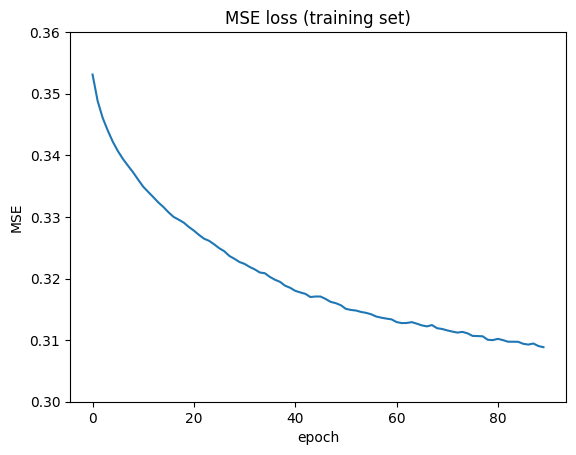

In [25]:
import matplotlib.pyplot as plt

plt.plot(X, losses)
plt.title('MSE loss (training set)')
plt.ylabel('MSE')
plt.xlabel('epoch');
plt.ylim(0.3, 0.36);

In [26]:
X = np.arange(90)
log_div = []
overlap = []
offroad = []

for e in range(90):
    log_div.append(np.array(training_dict[e]['validation']['log_divergence']).mean())
    overlap.append(np.array(training_dict[e]['validation']['overlap']).mean())
    offroad.append(np.array(training_dict[e]['validation']['offroad']).mean())

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2,3,1)
plt.plot(X, log_div)
plt.title('log_divergence (validation set)')
plt.ylabel('log_divergence (meter)')
plt.xlabel('epoch');

fig.add_subplot(2,3,2)
plt.plot(X, overlap)
plt.title('overlap (validation set)')
plt.ylabel('overlap')
plt.xlabel('epoch');

fig.add_subplot(2,3,3)
plt.plot(X, offroad)
plt.title('offroad (validation set)')
plt.ylabel('offroad')
plt.xlabel('epoch');


window_size = 10

smoothed_log_div = np.convolve(log_div, np.ones(window_size) / window_size, mode='valid')
smoothed_overlap = np.convolve(overlap, np.ones(window_size) / window_size, mode='valid')
smoothed_offroad = np.convolve(offroad, np.ones(window_size) / window_size, mode='valid')

# Plotting the smoothed curves

fig.add_subplot(2, 3, 4)
plt.plot(X[window_size - 1:], smoothed_log_div)
plt.title('Smoothed log_divergence (validation set)')
plt.ylabel('log_divergence')
plt.xlabel('epoch')

fig.add_subplot(2, 3, 5)
plt.plot(X[window_size - 1:], smoothed_overlap)
plt.title('Smoothed overlap (validation set)')
plt.ylabel('overlap')
plt.xlabel('epoch')

fig.add_subplot(2, 3, 6)
plt.plot(X[window_size - 1:], smoothed_offroad)
plt.title('Smoothed offroad (validation set)')
plt.ylabel('offroad')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()


## Learned policy

In [3]:
WOD_1_1_0_VALIDATION = _config.DatasetConfig(
    path=config['validation_path'],
    max_num_rg_points=config['max_num_rg_points'],
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=config['max_num_obj'],
)

data_iter = dataloader.simulator_state_generator(config=WOD_1_1_0_VALIDATION)
id = 0

In [4]:
scenario = next(data_iter)
id += 1

2023-11-20 16:29:44.421796: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
bicycle_dynamics_model = dynamics.InvertibleBicycleModel()
planning_dynamics_model = _env.PlanningAgentDynamics(bicycle_dynamics_model)

# Env config
env_config = _config.EnvironmentConfig(
    controlled_object=_config.ObjectType.SDC,
    max_num_objects=config['max_num_obj']
)
env = _env.PlanningAgentEnvironment(
            dynamics_model=bicycle_dynamics_model, # /!\ NOT the planning_dynamic_model otherwise repetition
            config=env_config,
            )

# DEFINE EXPERT AGENT
expert_agent = agents.create_expert_actor(planning_dynamics_model)

network = ActorCriticRNN(planning_dynamics_model.action_spec().shape[0],
                            feature_extractor_class=FlattenXYExtractor,
                            feature_extractor_kwargs={'max_num_obj': config['max_num_obj']},
                            config=config)

feature_extractor_shape = config['max_num_obj'] * 2

init_rnn_state = ScannedRNN.initialize_carry((config["num_envs"], feature_extractor_shape))
rng, _rng = jax.random.split(random.PRNGKey(config['key']))

init_x = (
    jnp.zeros(
        (1, config["num_envs"], config['max_num_obj'], 2)
    ),
    jnp.zeros((1, config["num_envs"]), dtype=bool),
)
# network_params = network.init(_rng, init_rnn_state, init_x)

tx = optax.chain(
    optax.clip_by_global_norm(config["max_grad_norm"]),
    optax.adam(config["lr"], eps=1e-5),
)

with open(os.path.join(load_folder, expe_num, 'params_99.pkl'), 'rb') as file:
    params = pickle.load(file)

train_state = TrainState.create(apply_fn=network.apply,
                                params=params,
                                tx=tx,
                                )

In [9]:
from typing import NamedTuple

class Transition(NamedTuple):
    done: jnp.ndarray
    expert_action: jnp.array
    obs: jnp.ndarray

init_rnn_state_eval = ScannedRNN.initialize_carry((config["num_envs_eval"], feature_extractor_shape))

def _log_step(current_state, unused):

    done = current_state.is_done
    obsv = ExtractXY(current_state, config)

    transition = Transition(done,
                            None,
                            obsv
    )

    # Update the simulator with the log trajectory
    current_state = datatypes.update_state_by_log(current_state, num_steps=1)

    return current_state, transition


In [21]:
# INIT ENV
current_state = env.reset(scenario)

# Compute the rnn_state on first env.config.init_steps from the log trajectory 
_, log_traj_batch = jax.lax.scan(_log_step, scenario, None, env.config.init_steps - 1) 
rnn_state, _, _ = network.apply(train_state.params, init_rnn_state_eval, (log_traj_batch.obs[:, jnp.newaxis, ...], log_traj_batch.done[:, jnp.newaxis, ...]))


In [22]:
imgs = []
scenario_metrics = {'log_divergence': [],
                    'overlap': [],
                    'offroad': []}

step = 0
while not current_state.is_done:
    step += 1
    imgs.append(visualization.plot_simulator_state(current_state, use_log_traj=False))
    
    done = jnp.tile(current_state.is_done, (config['num_envs_eval'],))
    full_obsv = datatypes.sdc_observation_from_state(current_state,
                                                roadgraph_top_k=config['roadgraph_top_k'])
    validv = full_obsv.is_ego
    obsv = full_obsv.trajectory.xy # /!\ TODO: need to remove the unvalid object

    expert_action = expert_agent.select_action(state=current_state,
                                            actor_state=None,
                                            params=None,
                                            rng=None)
    
    # Add a mask here
    
    rnn_state, data_action, _ = network.apply(train_state.params, rnn_state, (obsv[jnp.newaxis, ...], done[jnp.newaxis, ...]))
    action = datatypes.Action(data=data_action[0, 1], valid=jnp.ones((1), dtype='bool'))

    current_state = env.step(current_state, action)
    
    metric = env.metrics(current_state)

    for key, value in metric.items():
        if jnp.any(value.valid):
            scenario_metrics[key].append(value.value[value.valid])


In [35]:
mediapy.show_video(imgs, fps=10)

In [41]:
id = 'none'

In [ ]:
# Save as gif 
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

save_animation_folder = '../animation'
os.makedir(os.path.joint(save_animation_folder, expe_num))

# Save the frames as a GIF
frames[0].save(os.path.join(''), save_all=True, append_images=frames[1:], duration=200, loop=0)

## Ground truth

In [ ]:
state = scenario

imgs = []
for _ in range(scenario.remaining_timesteps):
  state = datatypes.update_state_by_log(state, num_steps=1)
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=True))

mediapy.show_video(imgs, fps=10)